This file contains the code for the following steps for the first strategy:
- building a Concept Lattice;
- 3 options for choosing the best concepts from lattice: the minimum number of the best by metric, random concepts, a larger number of the best by metric;
- selecting the best parameters for cross-validation for the Concept Network;
- visualization of the best Concept Network on two metrics f1 and recall.

In [1]:
# # I tried to run it in colab for a long time, but I managed to install all the dependencies only in jupyter-notebook
# !pip install fcapy
# #!pip install -U -q fcapy==0.1.4
# !pip install frozendict
# !pip install ipynb
# !pip install sparselinear
# !pip install bitsets
# !pip install opendatasets
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# # This installation method works for 2 hours, so I just installed it through the bottom lines, there was no version conflict
# # !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
# # !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
# # !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
# !pip install torch-cluster
# !pip install torch-sparse
# !pip install torch-scatter
# # !pip uninstall bitarray
# !pip install bitarray==2.7.5

In [2]:
# To comply with the code style
%load_ext jupyter_black

### Libraries

In [3]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import torch

# Preprocessing
from sklearn.model_selection import train_test_split

# FCA tools
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

# Model
import neural_lib62 as nl
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)

# Visualization
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)

/home/tk-lpt-0806/Desktop/MSDS/SEM1/OSDA/OSDA Project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
SEED = 42
STRATEGY_NUMBER = 1

### Dataset import

In [7]:
df_bin = pd.read_csv(f"processed/balanced_data.csv")

### Preparing index for ConceptLattice

In [8]:
df_bin = df_bin.set_index(np.arange(len(df_bin)).astype(str))

In [9]:
df_bin

income  age_under_18  age_18_24  age_25_34  age_35_44  age_45_54  \
0      True         False      False      False       True      False   
1      True         False      False      False      False       True   
2      True         False      False      False       True      False   
3      True         False      False       True      False      False   
4     False         False      False       True      False      False   
..      ...           ...        ...        ...        ...        ...   
995   False         False      False       True      False      False   
996   False         False      False      False      False      False   
997    True         False      False      False      False       True   
998   False         False      False       True      False      False   
999   False         False      False      False      False       True   

     age_55_64  age_65_plus  workclass_Private  workclass_Local-gov  ...  \
0        False        False               True                False  ...   
1        False        False               True                False  ...   
2        False        False              False                False  ...   
3        False        False               True                False  ...   
4        False        False               True                False  ...   
..         ...          ...                ...                  ...  ...   
995      False        False               True                False  ...   
996       True        False               True                False  ...   
997      False        False               True                False  ...   
998      False        False               True                False  ...   
999      False        False               True                False  ...   

     gender_male  hours_part_time  hours_full_time  hours_over_time  \
0           True            False            False             True   
1          False            False            False             True   
2           True            False            False             True   
3           True            False            False             True   
4          False             True            False            False   
..           ...              ...              ...              ...   
995         True            False             True            False   
996         True            False             True            False   
997        False            False             True            False   
998         True             True            False            False   
999         True            False             True            False   

     native_country_North America  native_country_South America  \
0                            True                         False   
1                            True                         False   
2                            True                         False   
3                            True                         False   
4                            True                         False   
..                            ...                           ...   
995                          True                         False   
996                          True                         False   
997                          True                         False   
998                          True                         False   
999                         False                         False   

     native_country_Central America  native_country_Europe  \
0                             False                  False   
1                             False                  False   
2                             False                  False   
3                             False                  False   
4                             False                  False   
..                              ...                    ...   
995                           False                  False   
996                           False                  False   

### Spliting the data to train and test

In [10]:
y = df_bin["income"]
X = df_bin.drop(columns=["income"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Concept Lattice

In [11]:
def build_lattice(X_train):
    K_train = FormalContext.from_pandas(X_train)
    L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
    print(len(L))
    # Compute metrics for each formal concept
    # (assuming that an object is predicted True if it is in the extent of the concept)
    for c in L:
        y_preds = np.zeros(K_train.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures["f1_score"] = f1_score(y_train, y_preds)
        c.measures["accuracy"] = accuracy_score(y_train, y_preds)
        c.measures["recall"] = recall_score(y_train, y_preds)
        c.measures["precision"] = precision_score(y_train, y_preds)
    return K_train, L

In [12]:
%%time

K_train, L = build_lattice(X_train)

102
CPU times: user 1.16 s, sys: 5.29 ms, total: 1.16 s
Wall time: 1.17 s


# Best concepts selecting

In [13]:
# Select indices of the best concepts from the lattice
def select_concepts_best(L, K_train, metric):
    n_concepts = 3  # Sometimes 1 is enough for this dataset, which seems strange
    while True:
        best_concepts = list(L.measures[metric].argsort()[::-1][:n_concepts])
        covered_indices = {g_i for c in L[best_concepts] for g_i in c.extent_i}
        if len(covered_indices) == K_train.n_objects:
            break
        n_concepts += 1
    return best_concepts

In [14]:
# Select indices of the (minimal+threshold) best concepts from the lattice
def select_concepts_more_best(L, K_train, threshold, metric):
    n_concepts = len(select_concepts_best(L, K_train, metric))
    best_concepts = list(L.measures[metric].argsort()[::-1][: (n_concepts + threshold)])
    return best_concepts

In [15]:
# Select indices of random concepts from the lattice
def select_concepts_random(L, K_train, metric):
    n_concepts = 3
    while True:
        best_concepts = list(
            np.random.choice(
                list(L.measures[metric].argsort()[::-1]), size=n_concepts, replace=False
            )
        )
        covered_indices = {g_i for c in L[best_concepts] for g_i in c.extent_i}
        if len(covered_indices) == K_train.n_objects:
            break
        n_concepts += 1
    return best_concepts

In [16]:
best_concepts_dict = {"f1_score": {}, "recall": {}}
for metric in ["f1_score", "recall"]:
    best_concepts_dict[metric]["best"] = select_concepts_best(L, K_train, metric)
    best_concepts_dict[metric]["more_best"] = select_concepts_more_best(
        L, K_train, 15, metric
    )
    best_concepts_dict[metric]["random"] = select_concepts_random(L, K_train, metric)

# Neural network

In [17]:
# Base method for neural network evaluate
def neural_network_base(L, best_concepts, n_epoch, func_nl):
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
    cn.fit(X_train, y_train, n_epochs=n_epoch, nonlinearity=func_nl)

    # predicting
    y_pred = cn.predict(X_test)[1]
    # y_proba = cn.predict_proba(X_test).detach().numpy()

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred[1])

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("----------------\n")

    return cn, recall, f1

In [18]:
# cross val score for ConceptNetwork
def neural_network(L, best_concepts, n_epoch, func_nl, num_folds=3):
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

    f1s, recalls = [], []
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

    for train_index, test_index in kf.split(X_train, y_train):
        x_train_curr, x_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_curr, y_val = y_train[train_index], y_train[test_index]

        cn.fit(x_train_curr, y_train_curr, n_epochs=n_epoch, nonlinearity=func_nl)

        y_pred = cn.predict(x_val)[1]
        # print("--------------------------------")
        # print("y_pred")
        # print(y_pred)
        # print("--------------------------------")
        # print("y_val")
        # print(y_val)
        # Convert PyTorch tensors to NumPy arrays if using PyTorch
        if isinstance(y_pred, torch.Tensor):
            y_pred = (
                y_pred.cpu().numpy()
            )  # Move to CPU if on GPU and convert to NumPy array
        y_val = y_val.astype(int).to_numpy()
        if isinstance(y_val, torch.Tensor):
            y_val = (
                y_val.cpu().numpy()
            )  # Move to CPU if on GPU and convert to NumPy array

        # Ensure both arrays are 1D
        y_pred = y_pred.reshape(-1)
        y_val = y_val.reshape(-1)

        # Check if both are integers (important for classification)
        y_pred = y_pred.astype(int)
        y_val = y_val.astype(int)
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

    f1 = np.mean(np.array(f1s))
    recall = np.mean(np.array(recalls))

    print(f"f1 mean: {f1}")
    print(f"recall mean: {recall}")
    print("----------------\n")

    return cn, recall, f1

In [19]:
# GridSearchCV for ConceptNetwork
def crossval_hyperparameter_tuning(metric="f1_score"):
    best_n = 0
    best_nnl = None
    best_type = "best"
    best_estimator = None
    best_metric_value = 0.0
    idx = 0
    metrics = {"n_epoch": [], "nnl": [], "bc_type": [], "f1": [], "recall": []}
    for n_epoch in n_epochs:
        for nnl in nonlinearities:
            for bc_type, bc in best_concepts_dict[metric].items():
                idx += 1
                print(f"Experiment {idx}")
                print(f"Parameters: n_epoch={n_epoch}, nnl={nnl}, bc_type={bc_type}")
                cn, recall, f1 = neural_network(L, bc, n_epoch, nnl)
                if metric == "recall":
                    check = recall
                else:
                    check = f1
                if check > best_metric_value:
                    best_metric_value = recall
                    best_n = n_epoch
                    best_nnl = nnl
                    best_type = bc_type
                    best_estimator = cn
                metrics["n_epoch"].append(n_epoch)
                metrics["nnl"].append(nnl)
                metrics["bc_type"].append(bc_type)
                metrics["f1"].append(f1)
                metrics["recall"].append(recall)
    return best_estimator, best_n, best_nnl, best_type, metrics

## Parameter tuning

In [20]:
n_epochs = [2000, 5000, 7000]
nonlinearities = [torch.nn.ReLU, torch.nn.Tanh, torch.nn.Sigmoid]

In [21]:
# Zero at a small value of n_epoch indicates an underfitting due to an ambulance of classes,
# and on large ones about overfitting (the model becomes a constant classifier)

In [22]:
y_train

29      True
535    False
695    False
557    False
836     True
       ...  
106     True
270    False
860    False
435    False
102     True
Name: income, Length: 800, dtype: bool

### Recall

In [23]:
%%time
(
    best_estimator_recall,
    best_n_recall,
    best_nnl_recall,
    best_type_recall,
    metrics_recall,
) = crossval_hyperparameter_tuning(metric="recall")

Experiment 1
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=best


f1 mean: 0.48392156862745095
recall mean: 0.6015037593984962
----------------

Experiment 2
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=more_best
f1 mean: 0.2745098039215686
recall mean: 0.2807017543859649
----------------

Experiment 3
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=random
f1 mean: 0.7725885174053887
recall mean: 0.8199416451576703
----------------

Experiment 4
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=best
f1 mean: 0.8002360400382167
recall mean: 0.8299480043392062
----------------

Experiment 5
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=more_best
f1 mean: 0.7923894065723562
recall mean: 0.8149665207795609
----------------

Experiment 6
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=random
f1 mean: 0.7854072341930318
recall mean: 0.8049414581229192
----------------

Experiment 7
Para

In [24]:
print(f"Best parameters for {'recall'}:")
print()
print(f"n_epoch={best_n_recall}")
print(f"nonlinearity={best_nnl_recall}")
print(f"best concepts selecting type={best_type_recall}")
print()


y_pred_recall = best_estimator_recall.predict(X_test)[1]
if isinstance(y_pred_recall, torch.Tensor):
    y_pred_recall = (
        y_pred_recall.cpu().numpy()
    )  # Move to CPU if on GPU and convert to NumPy array
# y_val = y_val.astype(int).to_numpy()
# if isinstance(y_val, torch.Tensor):
#     y_val = y_val.cpu().numpy()  # Move to CPU if on GPU and convert to NumPy array

# Ensure both arrays are 1D
y_pred_recall = y_pred_recall.reshape(-1)
# y_val = y_val.reshape(-1)
print(classification_report(y_test, y_pred_recall))
recall = recall_score(y_test, y_pred_recall)
f1 = f1_score(y_test, y_pred_recall)
print(f"Recall: {recall}")
print(f"F1: {f1}")

Best parameters for recall:

n_epoch=7000
nonlinearity=<class 'torch.nn.modules.activation.ReLU'>
best concepts selecting type=more_best

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       100
        True       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

Recall: 1.0
F1: 0.6666666666666666


### F1-score

In [25]:
%%time
best_estimator_f1, best_n_f1, best_nnl_f1, best_type_f1, metrics_f1 = (
    crossval_hyperparameter_tuning()
)

Experiment 1
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=best
f1 mean: 0.5299250810689925
recall mean: 0.543859649122807
----------------

Experiment 2
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=more_best
f1 mean: 0.4809259259259259
recall mean: 0.5964912280701754
----------------

Experiment 3
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=random
f1 mean: 0.7742408798500847
recall mean: 0.8376164291325328
----------------

Experiment 4
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=best
f1 mean: 0.7972054636723991
recall mean: 0.8249728799610967
----------------

Experiment 5
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=more_best
f1 mean: 0.7878610948331956
recall mean: 0.8100288033516628
----------------

Experiment 6
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=rand

In [27]:
print(f"Best parameters for {'f1'}:")
print()
print(f"n_epoch={best_n_f1}")
print(f"nonlinearity={best_nnl_f1}")
print(f"best concepts selecting type={best_type_f1}")
print()

y_pred_f1 = best_estimator_f1.predict(X_test)[1]
if isinstance(y_pred_f1, torch.Tensor):
    y_pred_f1 = (
        y_pred_f1.cpu().numpy()
    )  # Move to CPU if on GPU and convert to NumPy array
# y_val = y_val.astype(int).to_numpy()
# if isinstance(y_val, torch.Tensor):
#     y_val = y_val.cpu().numpy()  # Move to CPU if on GPU and convert to NumPy array

# Ensure both arrays are 1D
y_pred_f1 = y_pred_f1.reshape(-1)
print(classification_report(y_test, y_pred_f1))
recall = recall_score(y_test, y_pred_f1)
f1 = f1_score(y_test, y_pred_f1)
print(f"Recall: {recall}")
print(f"F1: {f1}")

Best parameters for f1:

n_epoch=2000
nonlinearity=<class 'torch.nn.modules.activation.ReLU'>
best concepts selecting type=random

              precision    recall  f1-score   support

       False       0.79      0.59      0.67       100
        True       0.67      0.84      0.75       100

    accuracy                           0.71       200
   macro avg       0.73      0.71      0.71       200
weighted avg       0.73      0.71      0.71       200

Recall: 0.84
F1: 0.7466666666666667


# Visualization

### Lattice visualization

In [28]:
def visualize_lattice(strategy_number, L):
    fig, ax = plt.subplots(figsize=(20, 20))
    vsl = LineVizNx()
    vsl.draw_concept_lattice(
        L,
        ax=ax,
        flg_node_indices=True,
        flg_new_intent_count_prefix=False,
        flg_new_extent_count_prefix=False,
    )

    plt.tight_layout()
    plt.savefig(f"visualization/lattice_for_{strategy_number}_strategy.png")
    plt.show()

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(30, 95): frozenset({8, 68}), (35, 90): frozenset({25}), (35, 91): frozenset({58}), (38, 87): frozenset({42}), (91, 101): frozenset({95}), (93, 101): frozenset({94})}


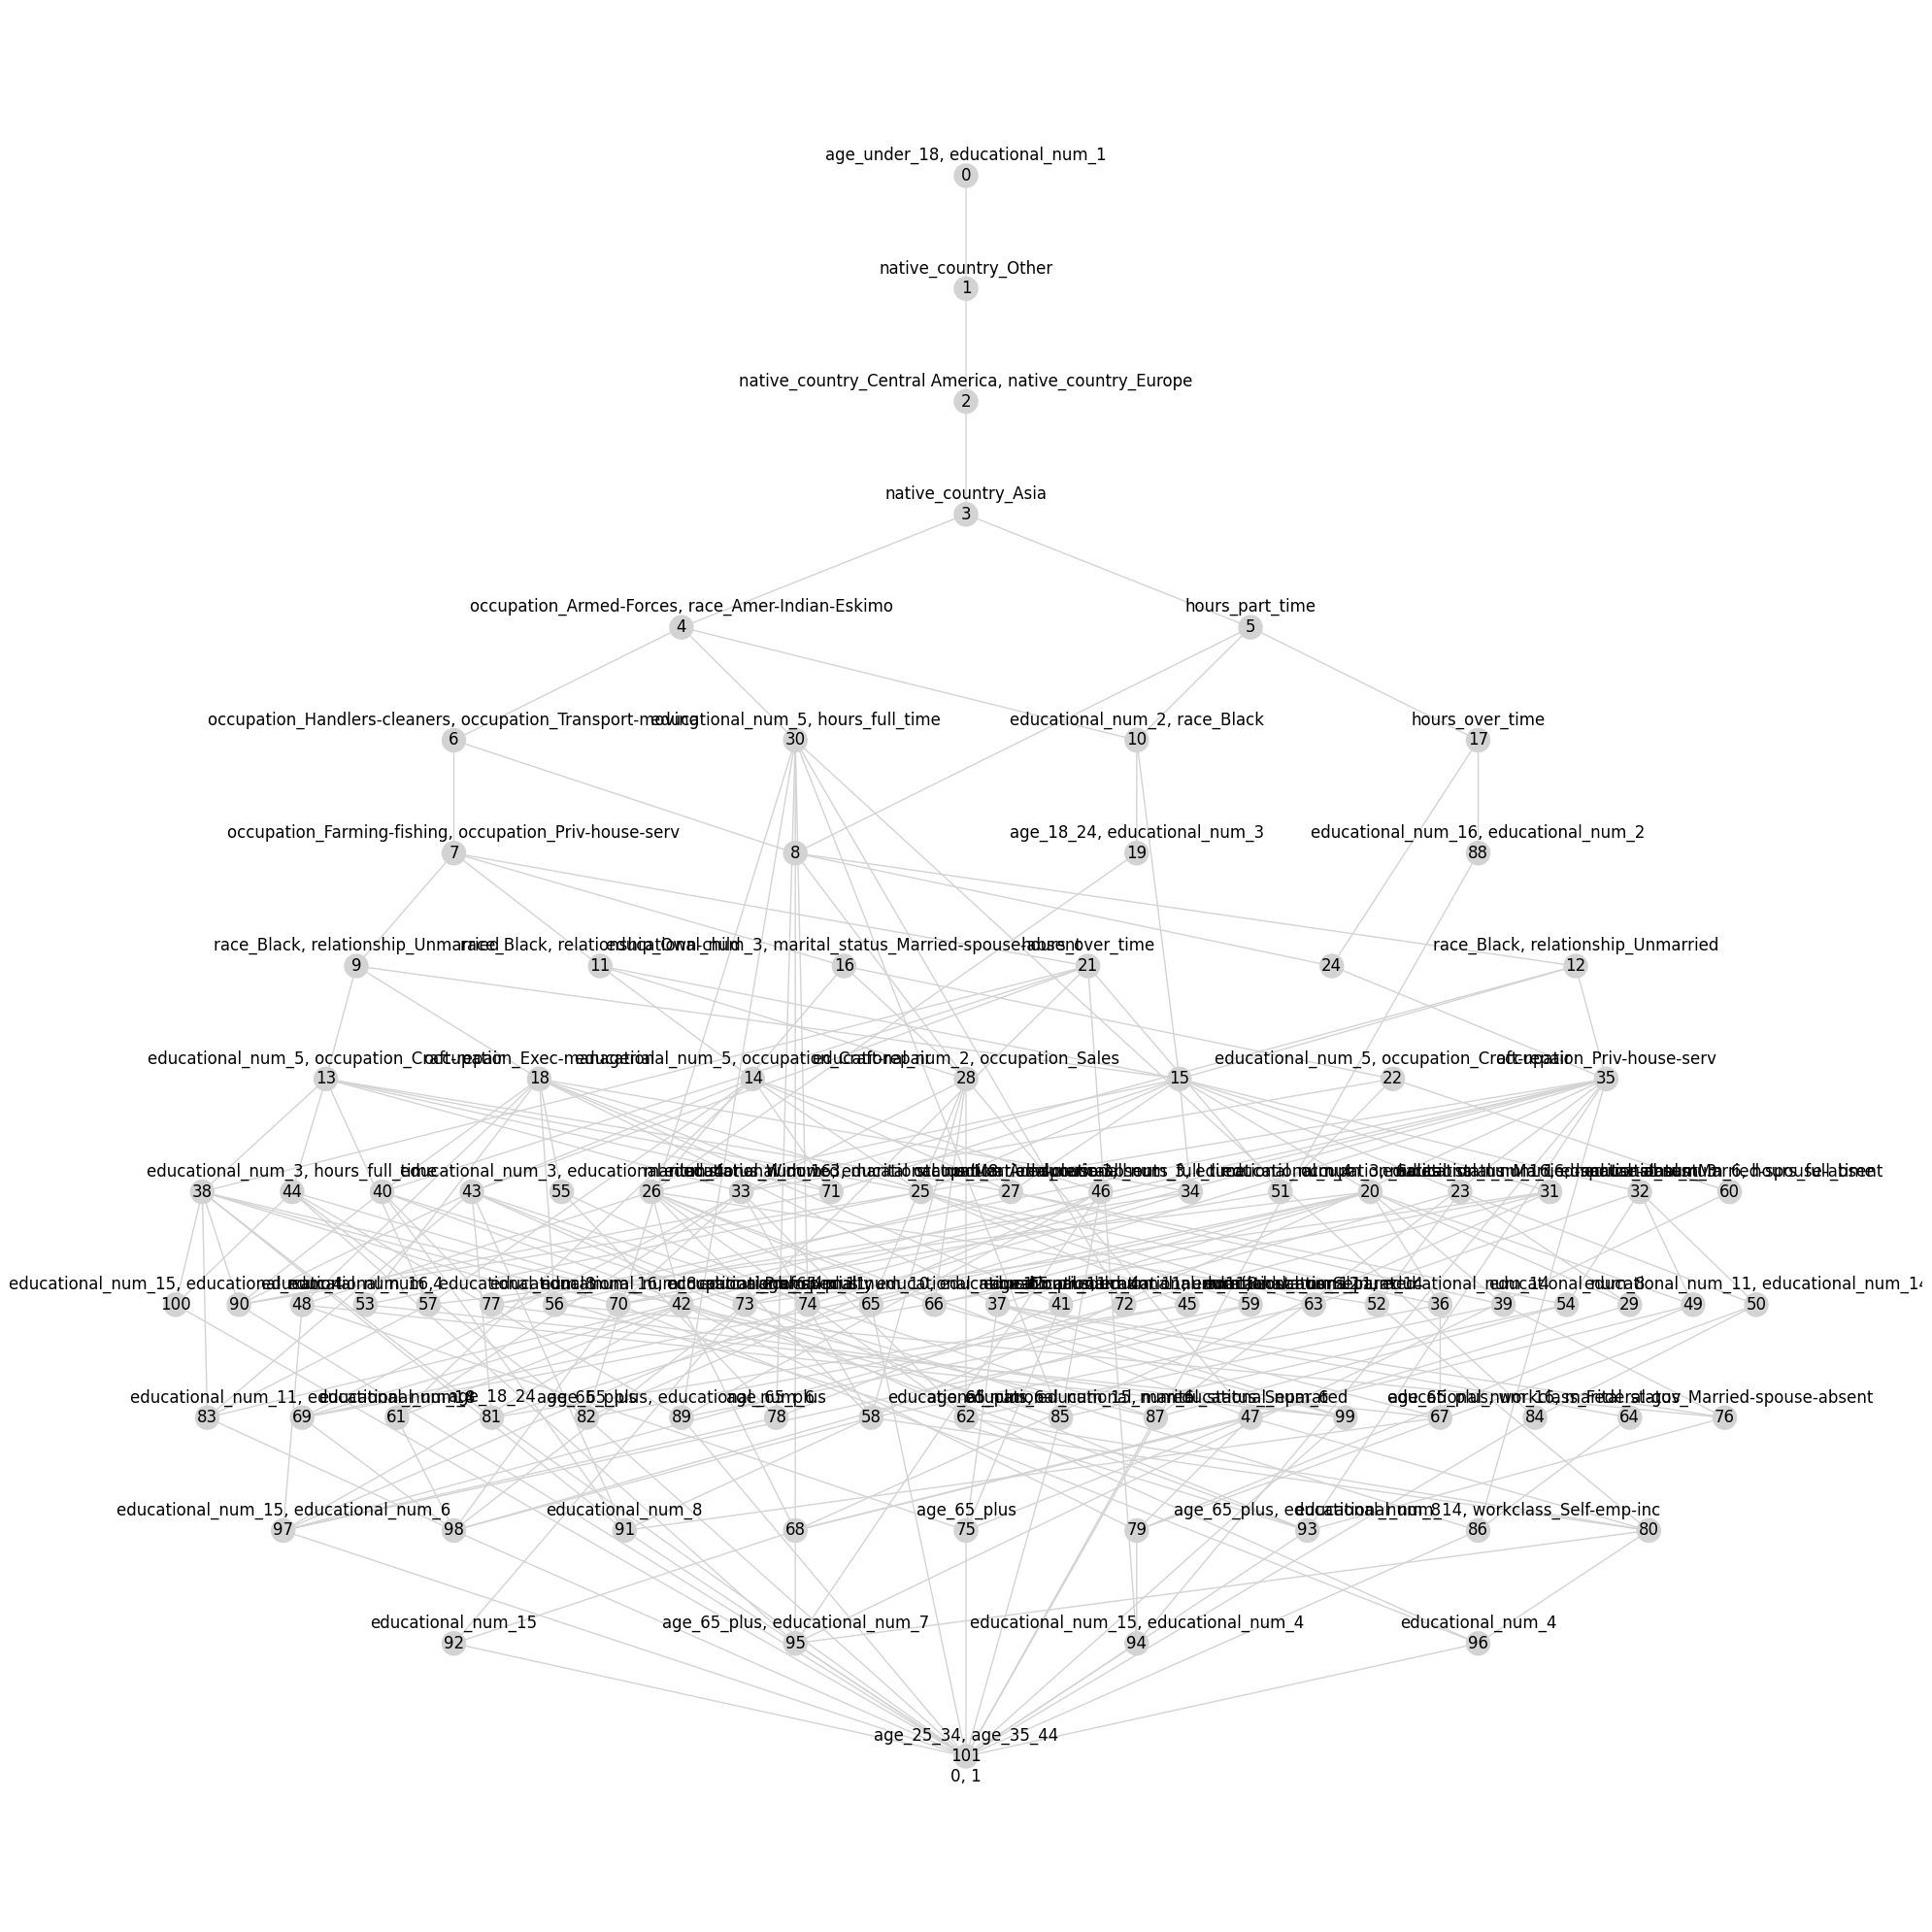

In [30]:
visualize_lattice(STRATEGY_NUMBER, L)

### Unfitted network 

In [ ]:
def visualize_unfitted_network(strategy_number, cn, n_concepts, metric):
    # Setup visuzalier for the architecture
    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes)
        )
        + "\n\n",
    )

    descr = {"smokes", "bmi_ge_30", "age_ge_45"}
    traced = cn.trace_description(descr, include_targets=False)

    fig, ax = plt.subplots(figsize=(30, 8))
    lst = ["\n"] * len(set(cn.attributes))
    for i in range(0, len(set(cn.attributes)), 2):
        lst[i] += "\n"

    vis.draw_poset(
        cn.poset,
        ax=ax,
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes), only_new_attrs=True
        ),
        # + f"\n\n\n{'\n\n\n' * (el_i % 3)}",
        node_color=[
            "darkblue" if el_i in traced else "lightgray"
            for el_i in range(len(cn.poset))
        ],
        node_size=100,
        node_label_font_size=8,
    )
    plt.title(
        f"NN based on "
        + str(n_concepts)
        + " best concepts from monotone concept lattice",
        loc="left",
        x=0.05,
        size=24,
    )

    plt.text(
        max(vis.mover.posx),
        min(vis.mover.posy) - 0.3,
        f"*Blue neurons are the ones activated by description {descr}",
        fontsize=14,
        ha="right",
        color="dimgray",
    )

    plt.subplots_adjust()
    plt.tight_layout()
    plt.savefig(f"visualization/unfitted_for_strategy_{strategy_number}_{metric}.png")
    plt.show()

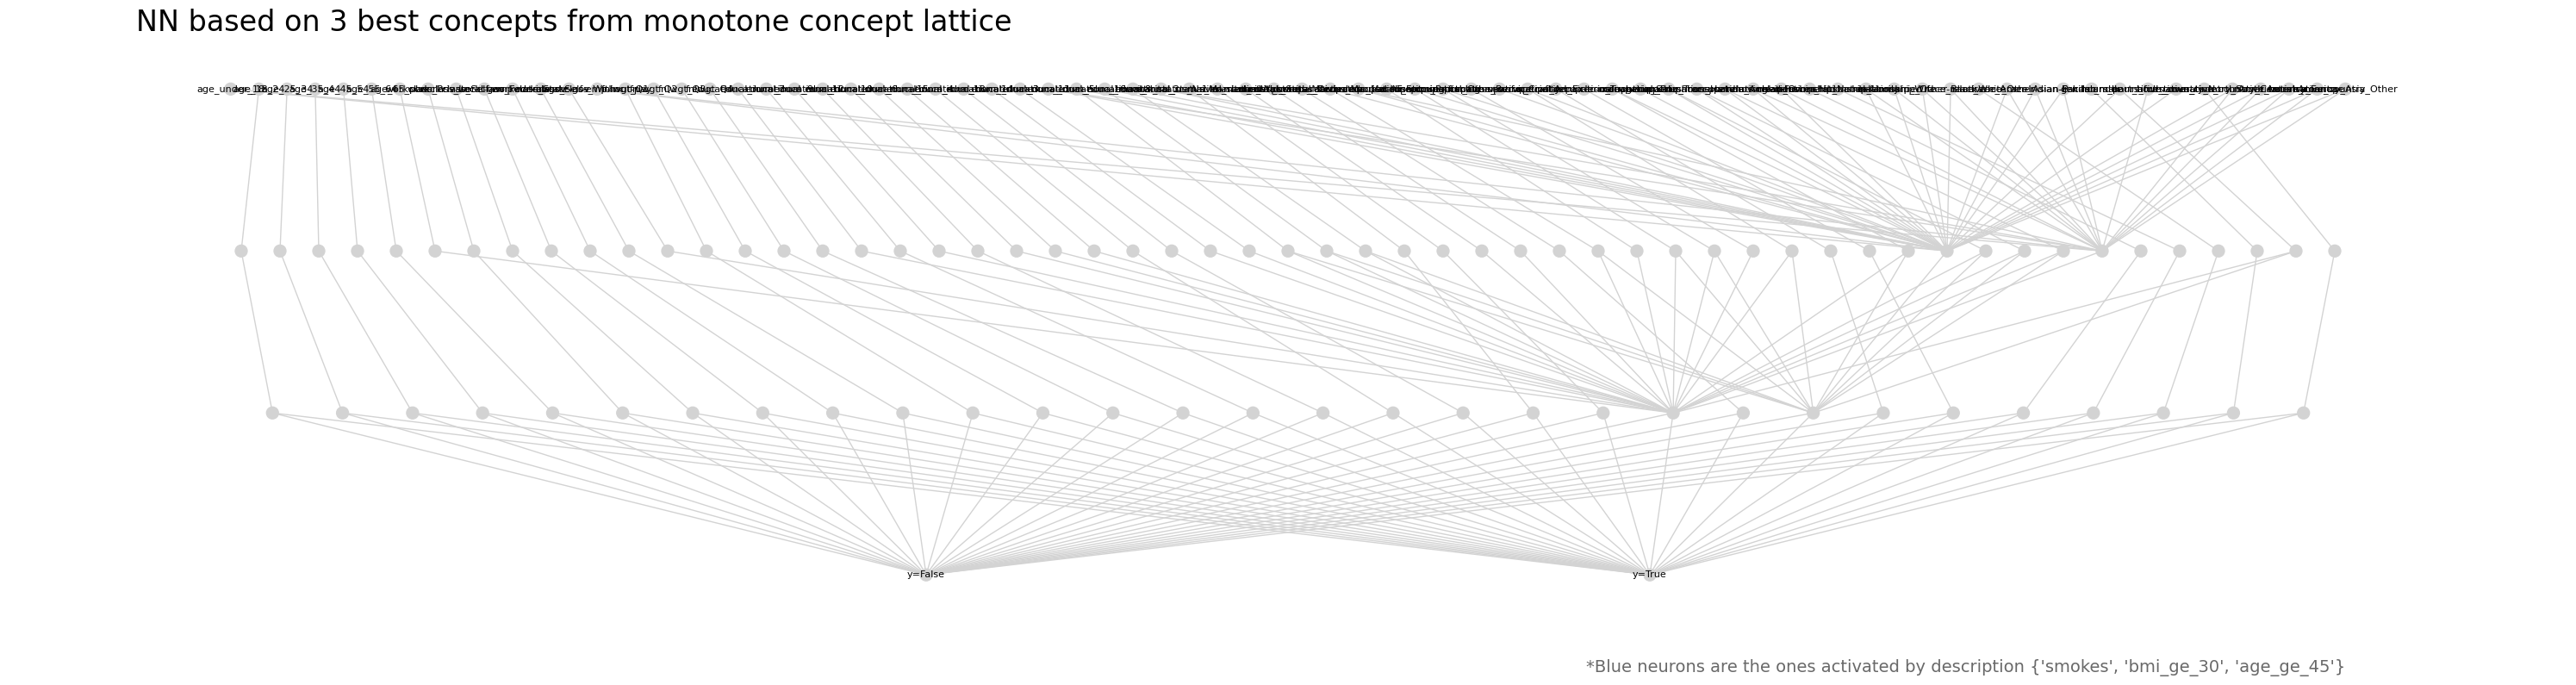

In [34]:
n_concepts = len(best_concepts_dict["f1_score"][best_type_f1])
visualize_unfitted_network(STRATEGY_NUMBER, best_estimator_f1, n_concepts, "f1")

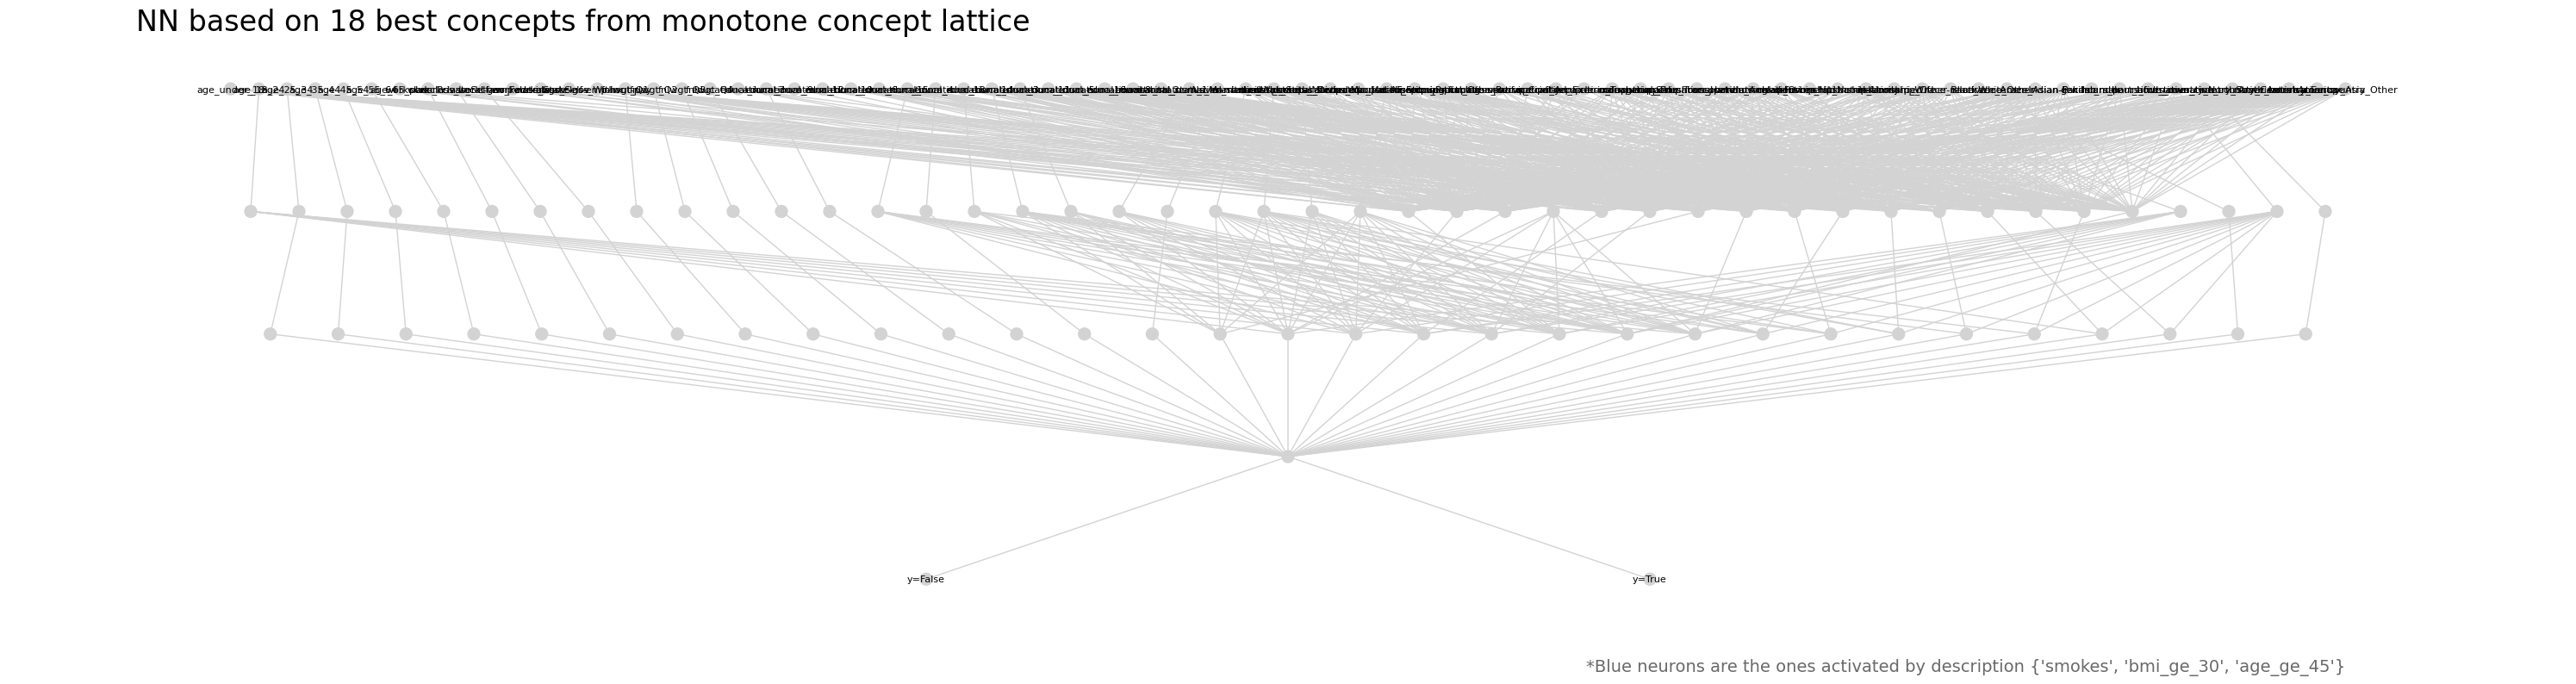

In [35]:
n_concepts = len(best_concepts_dict["recall"][best_type_recall])
visualize_unfitted_network(STRATEGY_NUMBER, best_estimator_recall, n_concepts, "recall")

### Fitted network

In [39]:
def fitted_visualization(strategy_number, cn, metric):
    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes)
        )
        + "\n\n",
    )
    edge_weights = cn.edge_weights_from_network()

    fig, ax = plt.subplots(figsize=(40, 20))

    vis.draw_poset(
        cn.poset,
        ax=ax,
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes), only_new_attrs=True
        )
        + f"\n\n\n\n\n\n",
        edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
        edge_cmap=plt.cm.RdBu,
    )
    nx.draw_networkx_edge_labels(
        cn.poset.to_networkx(),
        vis.mover.pos,
        {k: f"{v:.1f}" for k, v in edge_weights.items()},
        label_pos=0.7,
    )

    plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
    plt.tight_layout()
    plt.subplots_adjust()
    plt.savefig(
        f"visualization/fitted_network_for_strategy_{strategy_number}_{metric}.png"
    )
    plt.show()

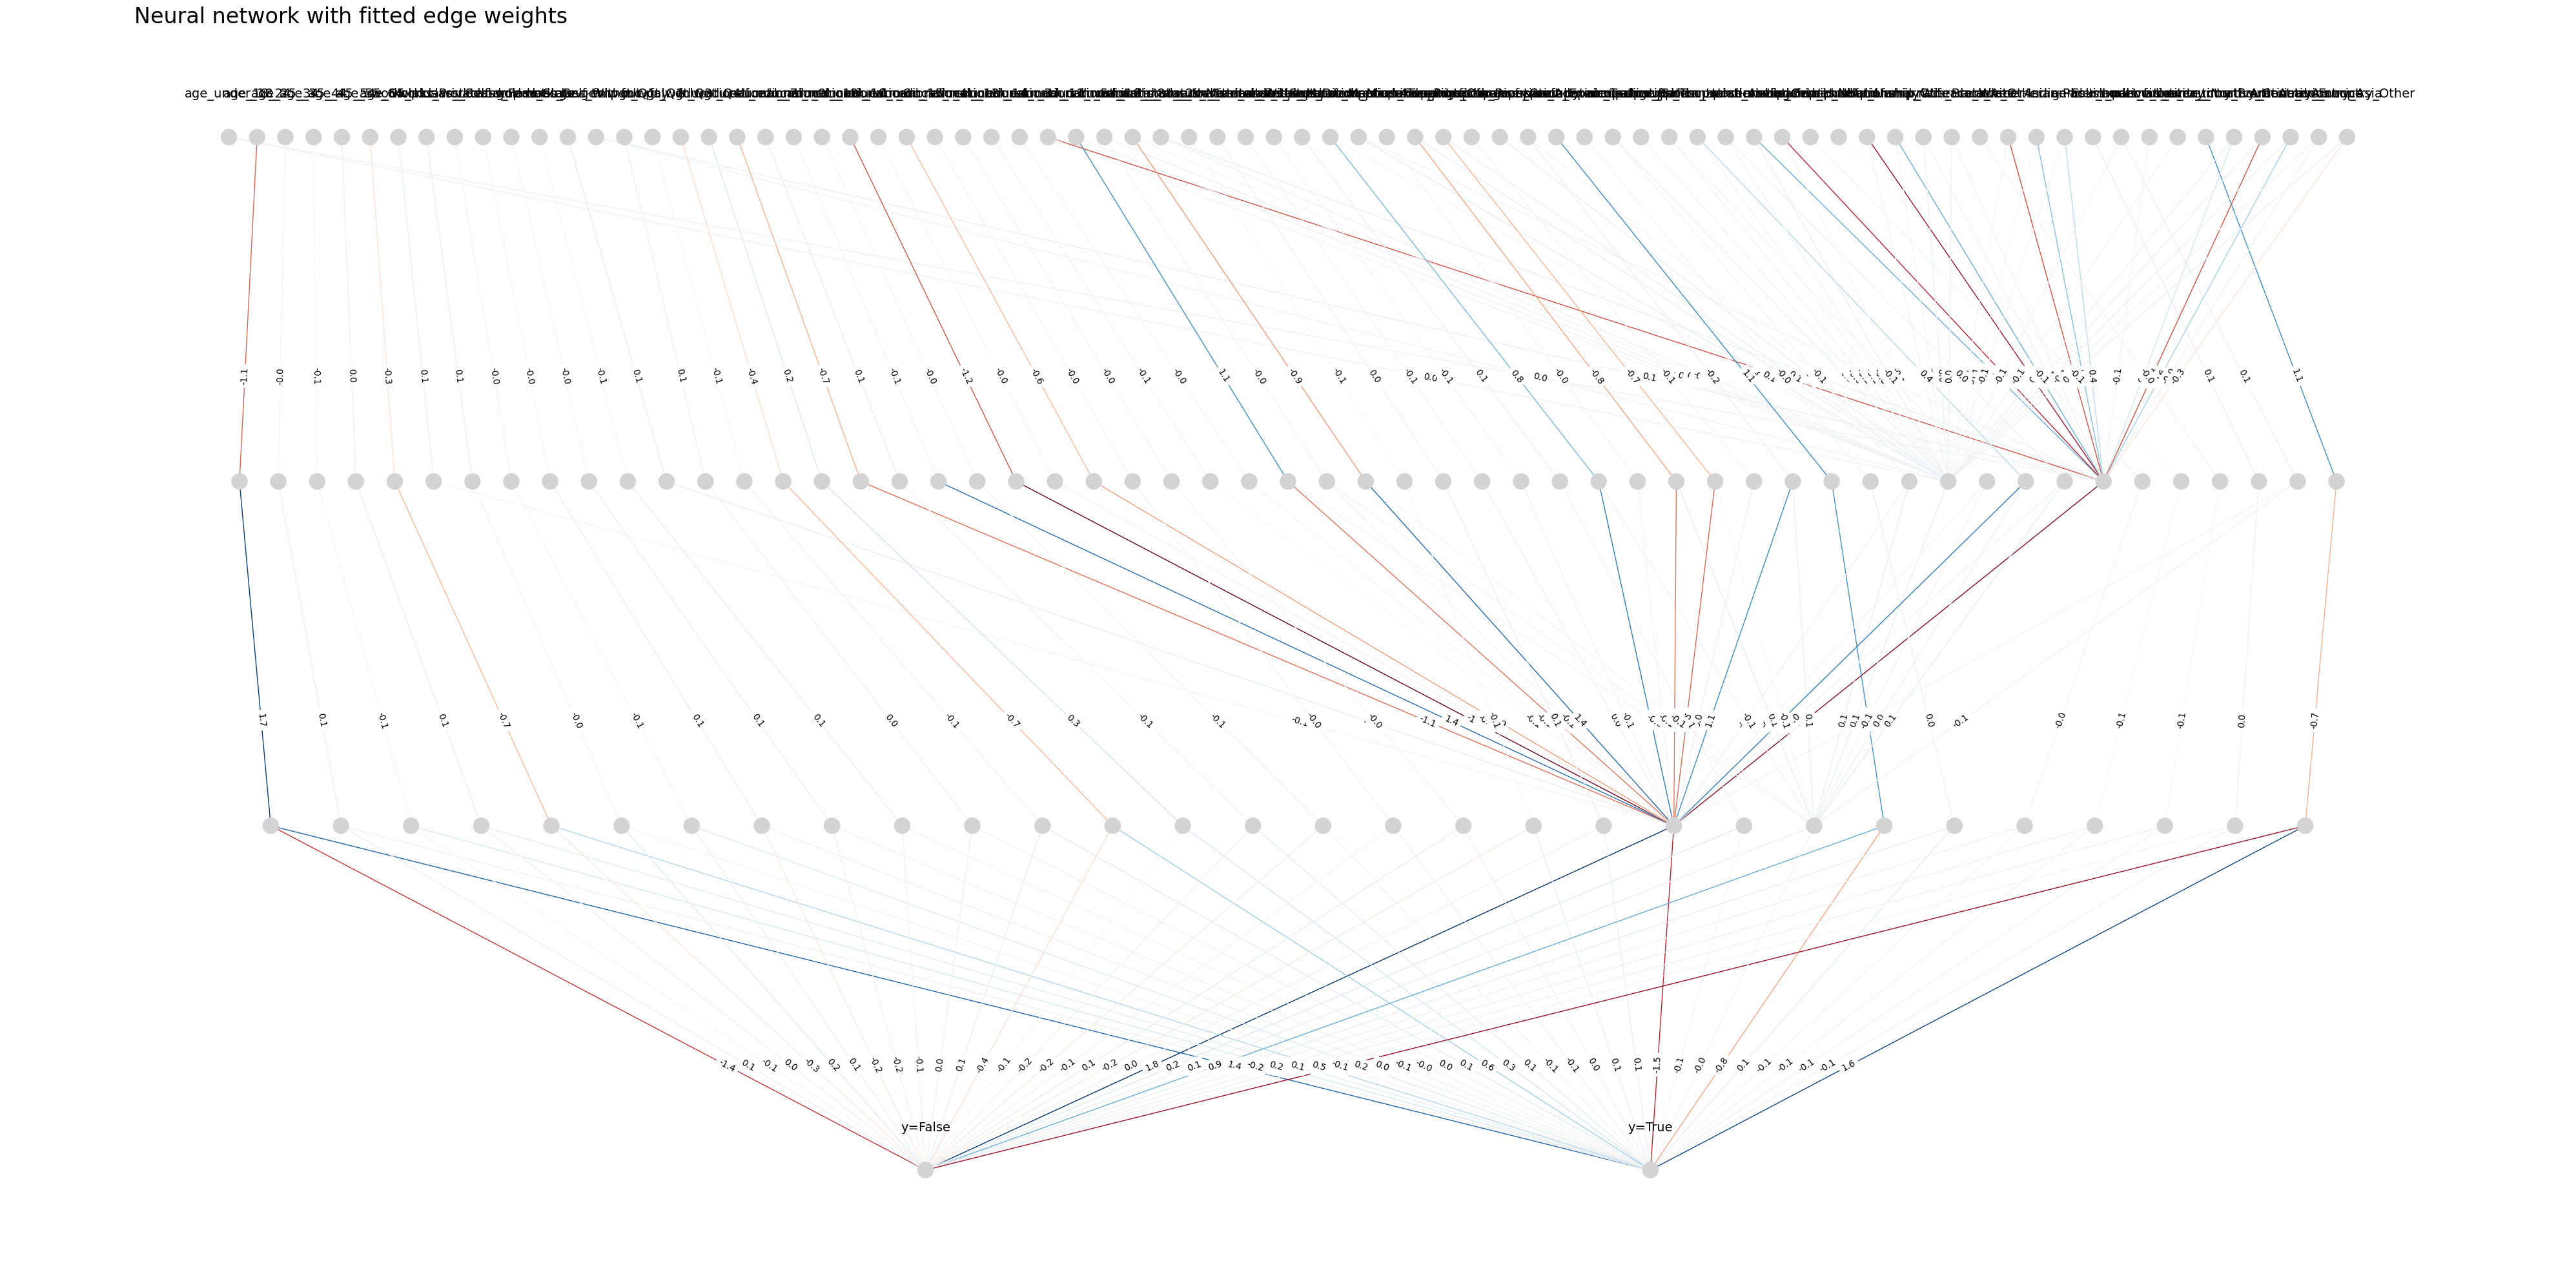

In [40]:
fitted_visualization(STRATEGY_NUMBER, best_estimator_f1, "f1")

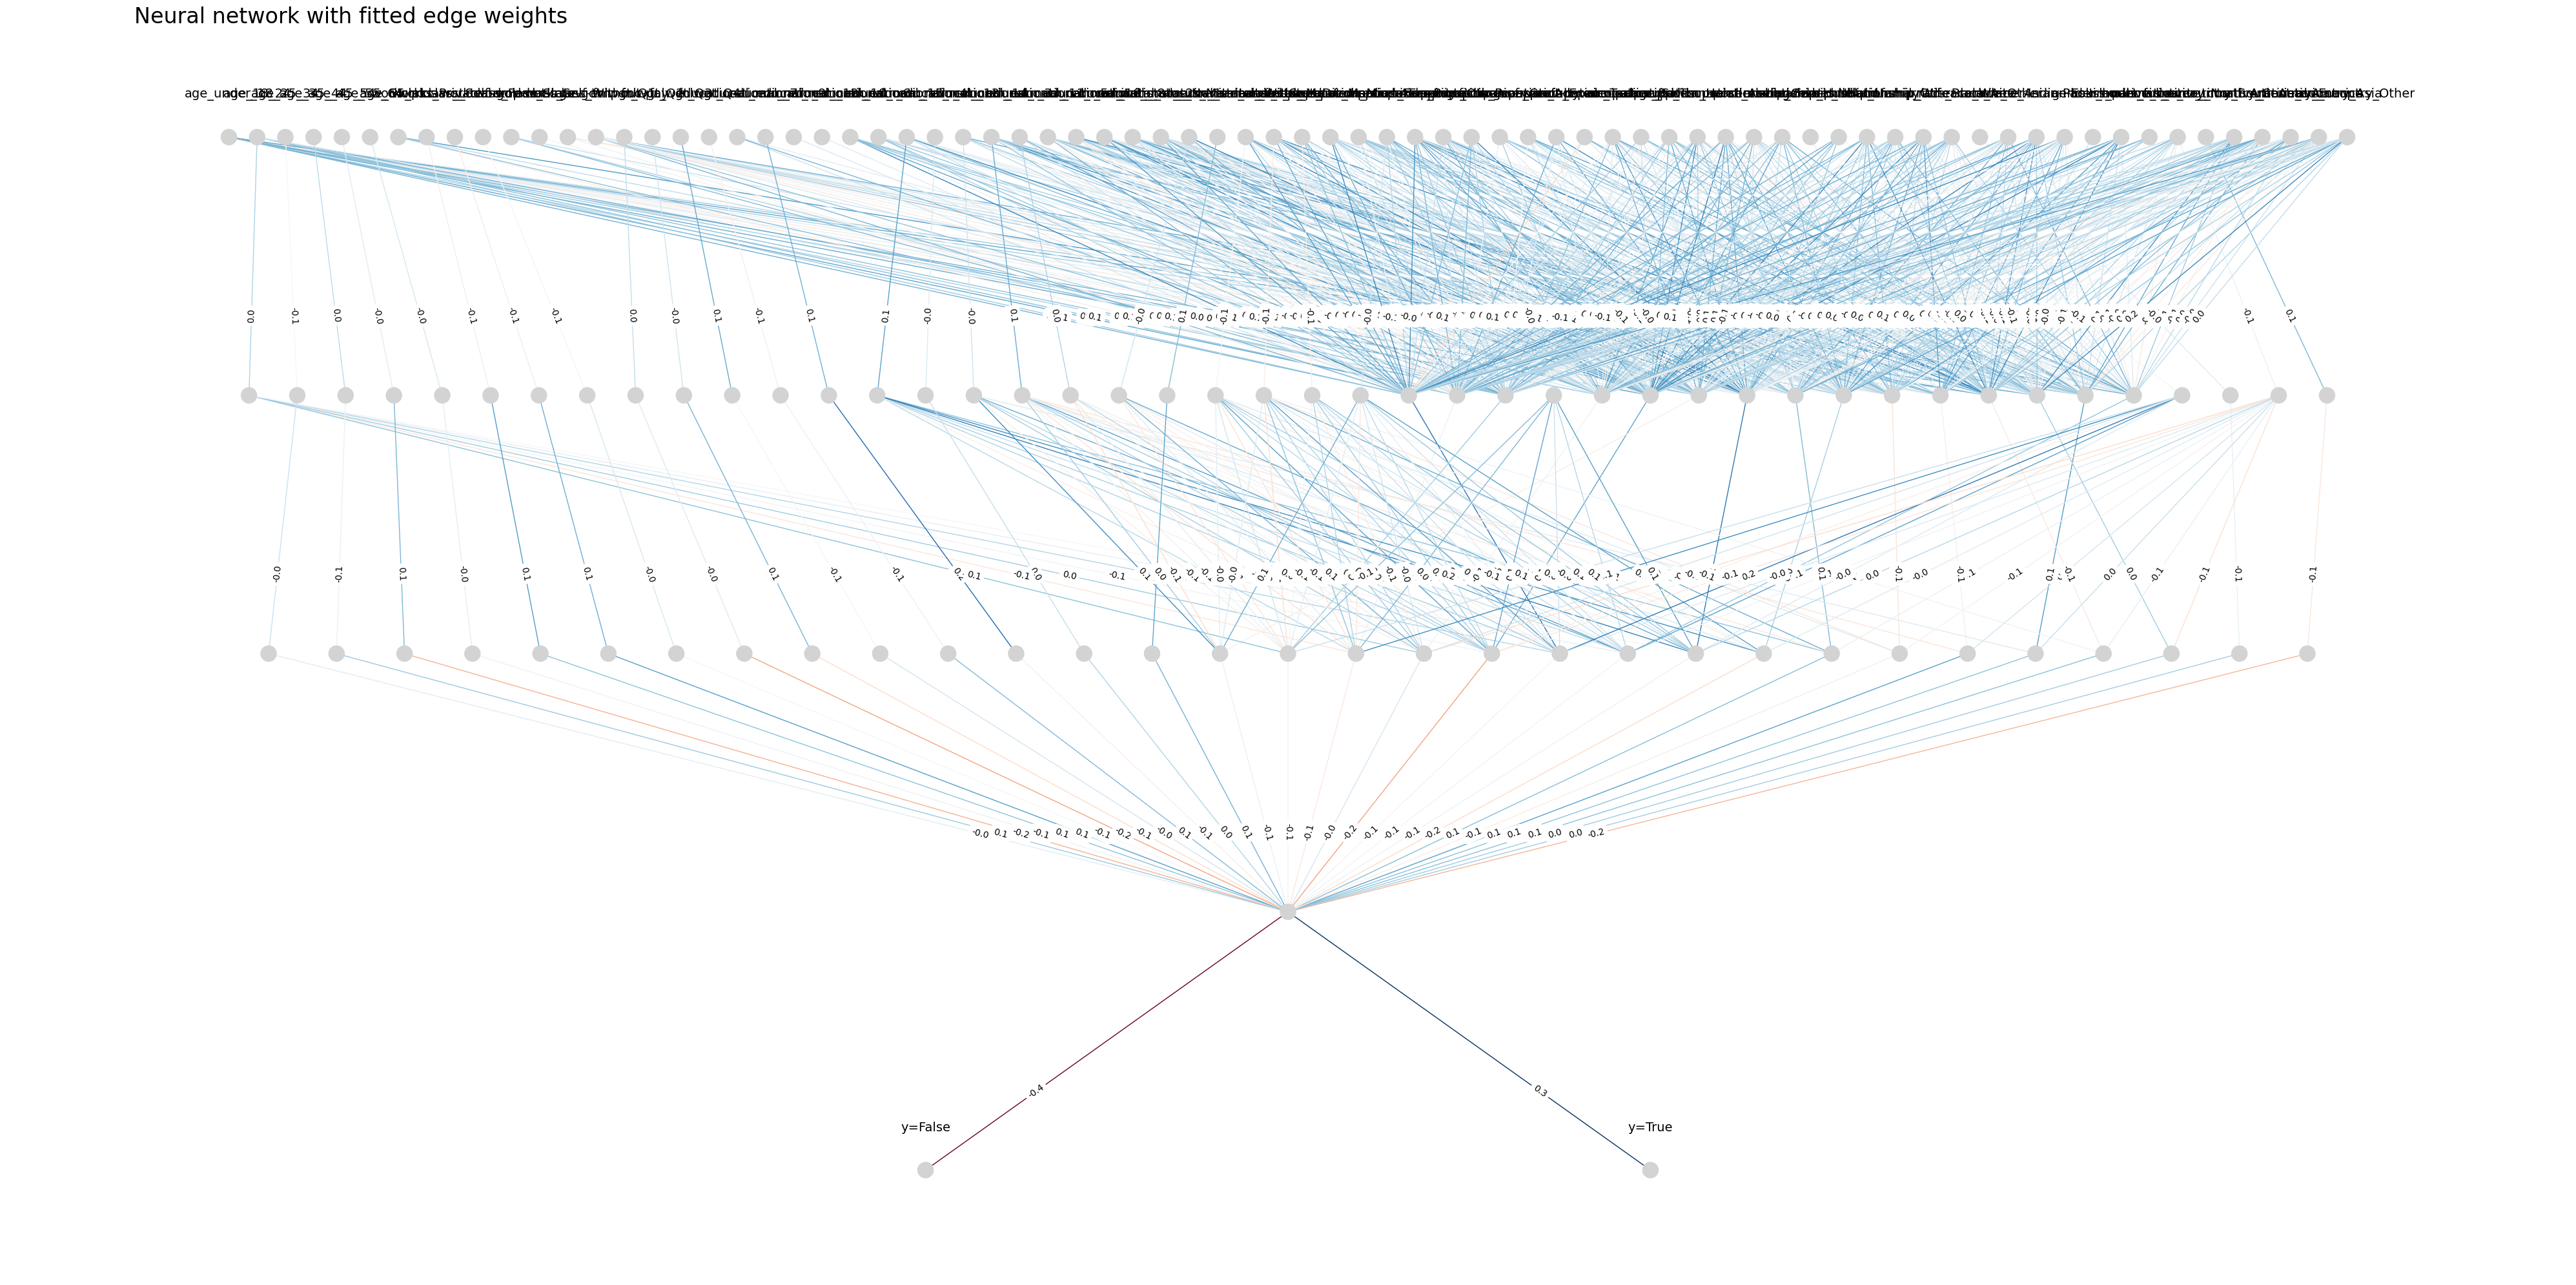

In [41]:
fitted_visualization(STRATEGY_NUMBER, best_estimator_recall, "recall")

## Dependencies

In [43]:
r = pd.DataFrame(metrics_recall)
f = pd.DataFrame(metrics_f1)
r.to_csv(f"processed/m_rec_{STRATEGY_NUMBER}.csv")
f.to_csv(f"processed/m_f_{STRATEGY_NUMBER}.csv")

In [44]:
r = pd.read_csv(f"processed/m_rec_{STRATEGY_NUMBER}.csv", index_col=0)
f = pd.read_csv(f"processed/m_f_{STRATEGY_NUMBER}.csv", index_col=0)

### Nonlinearity function influence

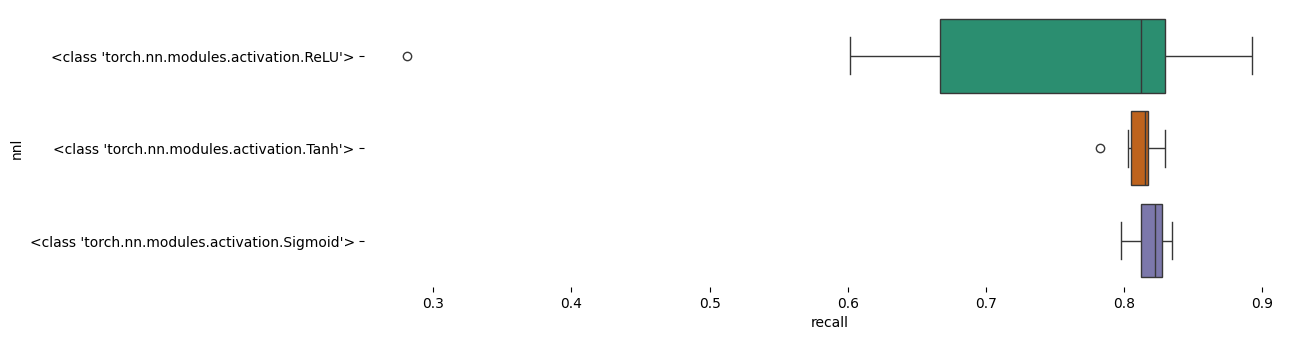

In [45]:
figsize = (12, 1.2 * len(r["nnl"].unique()))
plt.figure(figsize=figsize)
sns.boxplot(r, x="recall", y="nnl", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

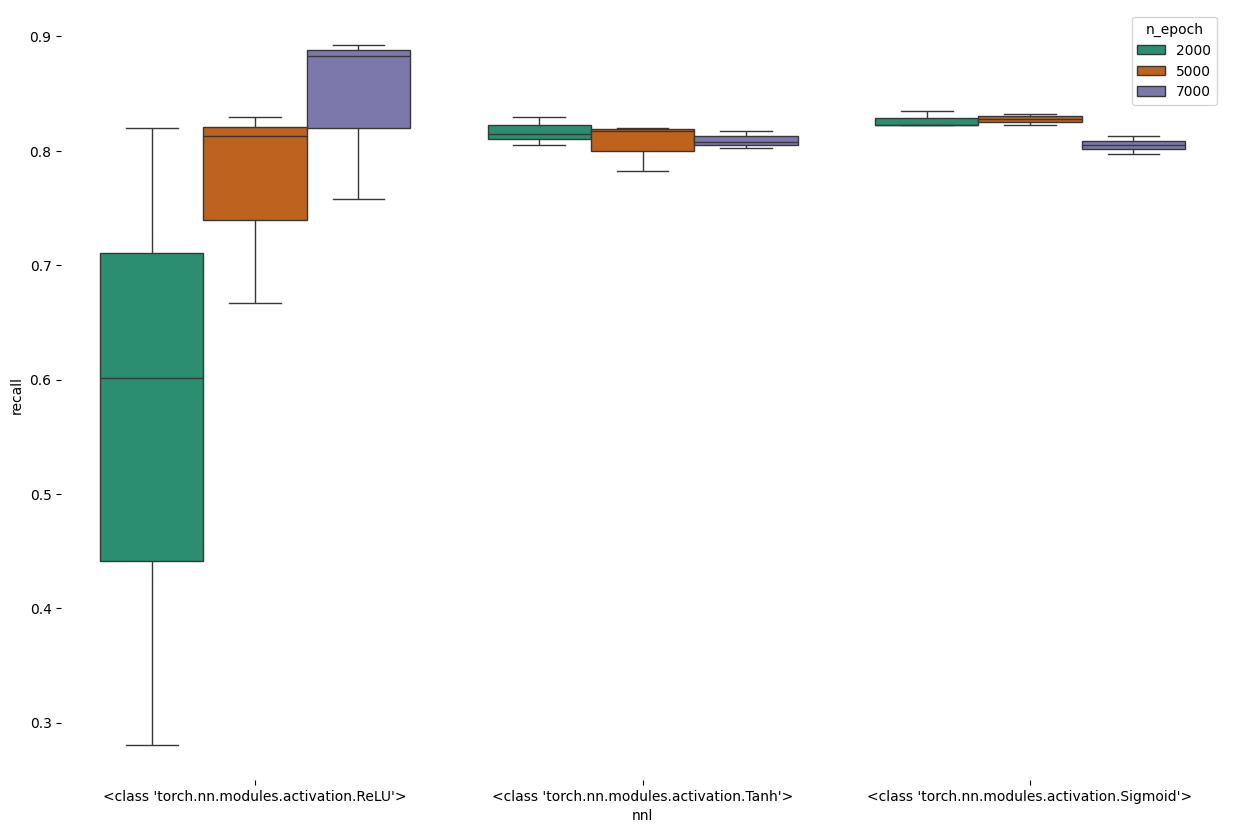

In [46]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="nnl", y="recall", hue="n_epoch", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

### Best concepts way influence

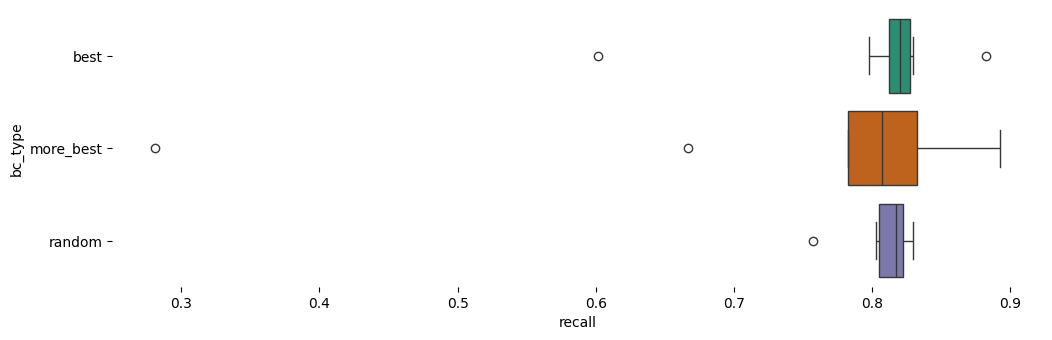

In [47]:
figsize = (12, 1.2 * len(r["bc_type"].unique()))
plt.figure(figsize=figsize)
sns.boxplot(r, x="recall", y="bc_type", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

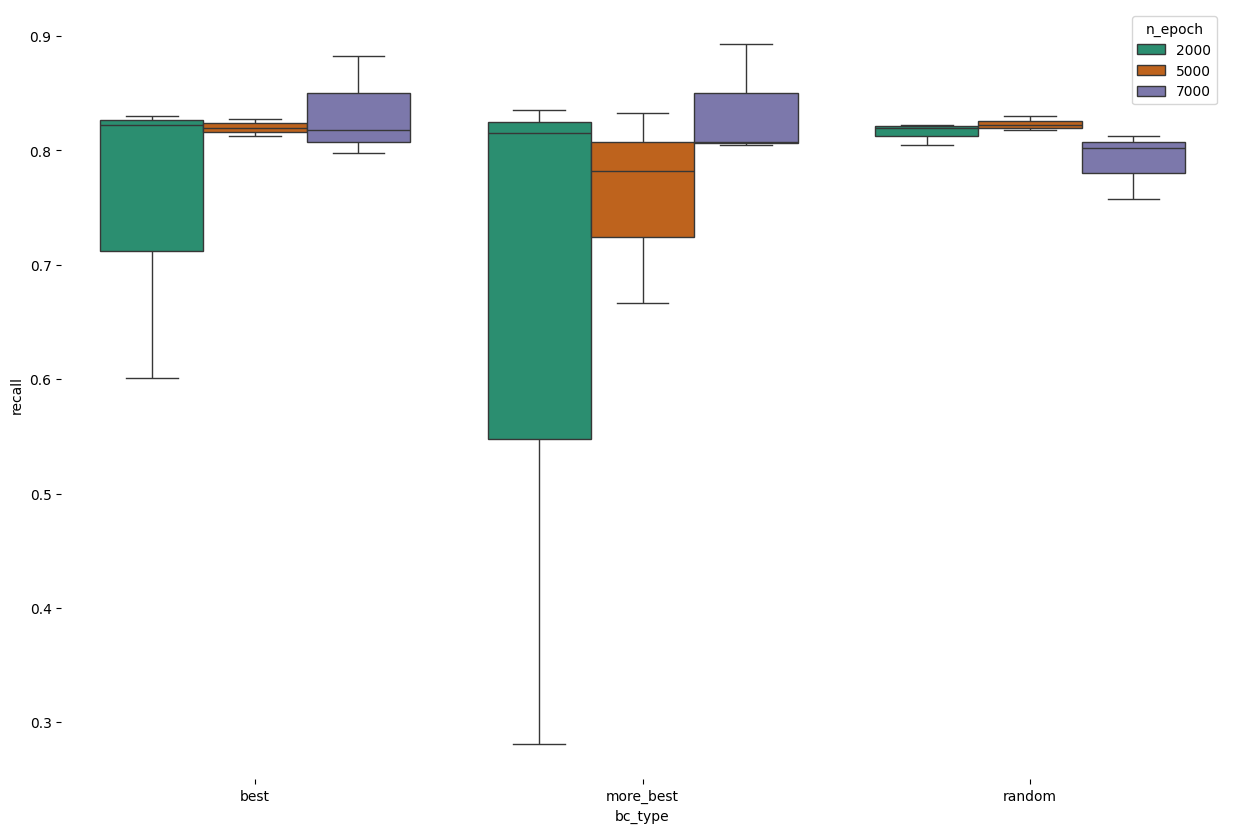

In [48]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="bc_type", y="recall", hue="n_epoch", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

### Best concepts way with nonlinearity dependence

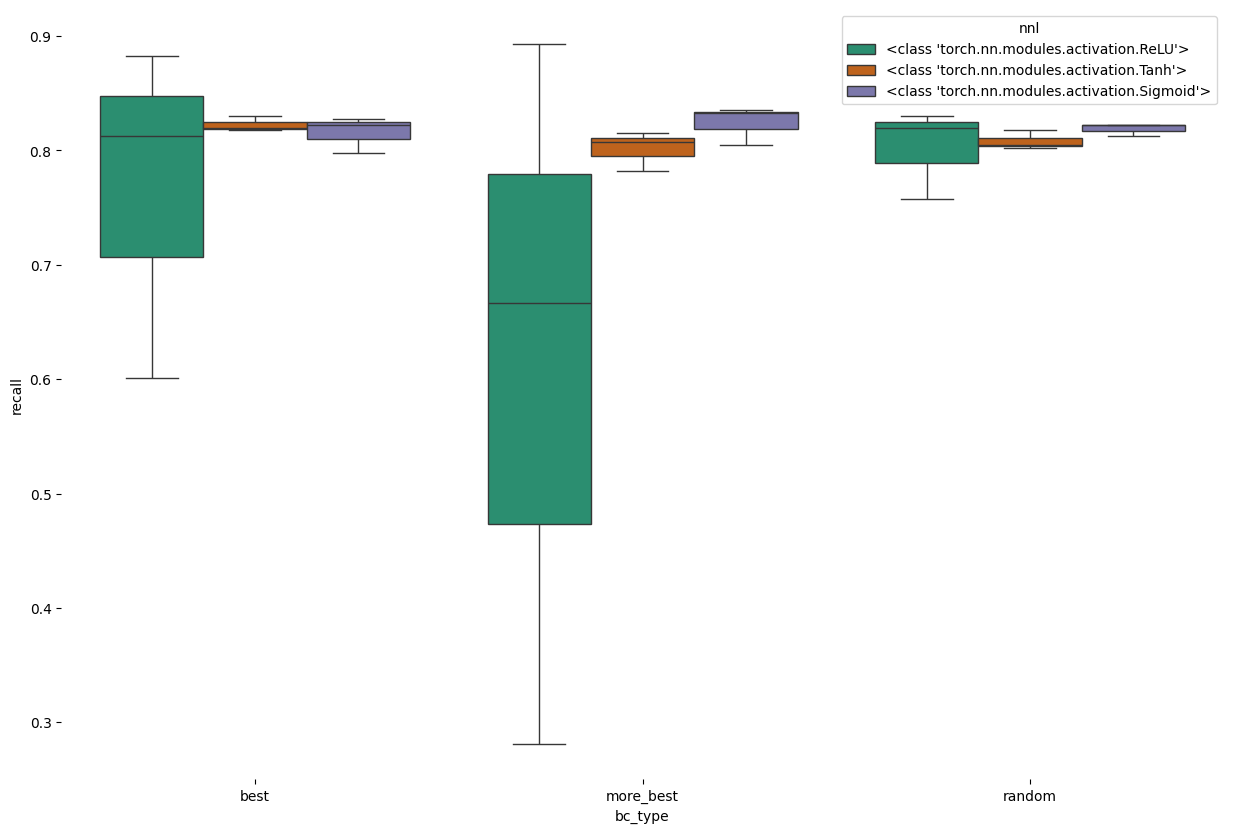

In [49]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="bc_type", y="recall", hue="nnl", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)